In this competition, you will be predicting the degradation rates at various locations along RNA sequence.

There are multiple ground truth values provided in the training data. While the submission format requires all 5 to be predicted, only the following are scored: reactivity, deg_Mg_pH10, and deg_Mg_50C.

In [2]:
# Dictionnary linking the column names and their definition for easier comprehension
DictColumns={'id' : 'An arbitrary identifier for each sample.' ,
             'sequence' : '(1x107 string in Train and Public Test, 130 in Private Test) Describes the RNA sequence, a combination of A, G, U, and C for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in seq_scored (note: indexed starting at 0)',
             'structure' : '(1x107 string in Train and Public Test, 130 in Private Test) An array of (, ), and . characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired', 
             'predicted_loop_type' : '(1x107 string) Describes the structural context (also referred to as loop type) of each character in sequence. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop', 
             'signal_to_noise' : 'S/N' ,
             'SN_filter' : 'Indicates if the sample passed filters described below in Additional Notes.', 
             'seq_length' : '(107 in Train and Public Test, 130 in Private Test) Integer values, denotes the length of sequence. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.', 
             'seq_scored' : '(68 in Train and Public Test, 91 in Private Test) Integer value denoting the number of positions used in scoring with predicted values. This should match the length of reactivity, deg_* and *_error_* columns. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.', 
             'reactivity_error' : 'see reactivity',
             'deg_error_Mg_pH10' : 'Error on the measured value', 
             'deg_error_pH10' : 'Error on the measured value',
             'deg_error_Mg_50C' : 'Error on the measured value',
             'deg_error_50C' : 'Error on the measured value', 
             'reactivity' : '(1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likely secondary structure of the RNA sample', 
             'deg_Mg_pH10' : '(1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10)', 
             'deg_pH10' : '(1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high pH (pH 10)', 
             'deg_Mg_50C' : '(1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).',
             'deg_50C' : '(1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high temperature (50 degrees Celsius).'}

**Import packages**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import json
import re
import tensorflow as tf
import os
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## Read data 
**Separate into private and public set**

In [117]:
print(os.getcwd())

/mnt/c/Users/ASUS/Desktop/M2_BI/Projet_Kaggle_Covid/OpenVaccine


In [118]:
train_df = pd.read_json('train.json',  lines = True).drop(['index'], axis = 1)
test_df = pd.read_json('test.json', lines = True).drop(['index'], axis = 1)
train_df_public = train_df.query("signal_to_noise >= 1")
train_df_private = train_df.query("SN_filter == 1")
test_df_public = test_df.query("seq_length == 130")
test_df_private = test_df.query("seq_length == 107")

In [6]:
train_df.head(5)

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [7]:
test_df.head(3)

,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68


## **signal_to_noise feature**

/home/skastalli/miniconda3/envs/KERAS/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


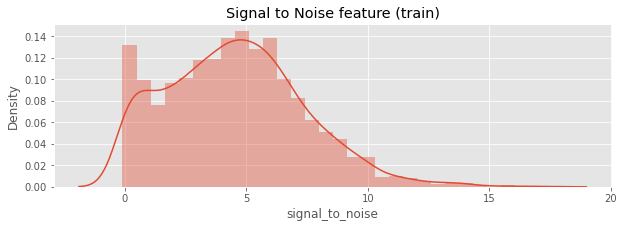

In [8]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 3))
ax = sns.distplot(train_df['signal_to_noise'])
ax.set_title('Signal to Noise feature (train)')
plt.show()

## seq_length

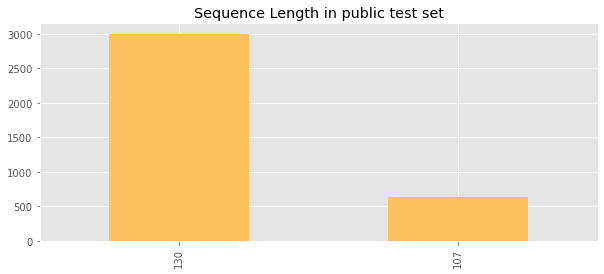

In [9]:
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
test_df['seq_length'].value_counts() \
    .plot(kind='bar', figsize=(10, 4),
          color=color_pal[4],
         title='Sequence Length in public test set')
plt.show()

## Visualisation

In [10]:
deg_pH10_df=train_df.deg_pH10.str[0]

2.0051375833333336
2.03145


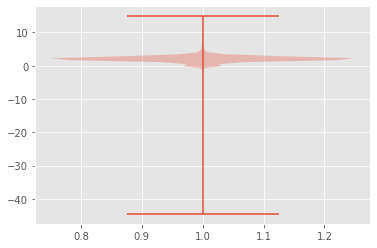

2.9236005833333336
2.88565


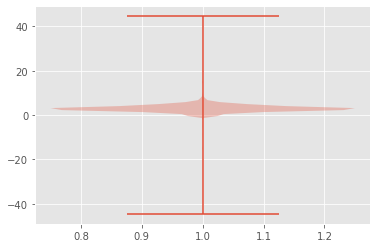

0.9287797083333333
0.98455


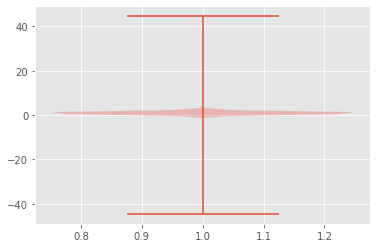

0.7225458333333333
0.7016500000000001


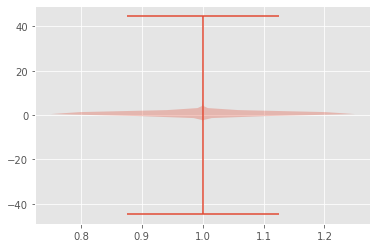

0.740868125
0.6605000000000001


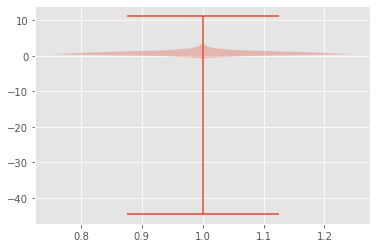

0.6808985416666666
0.6056


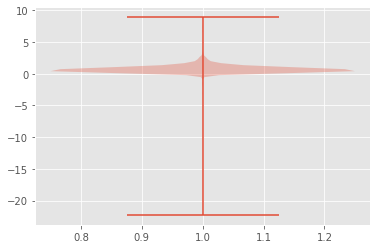

0.5717465833333334
0.46645000000000003


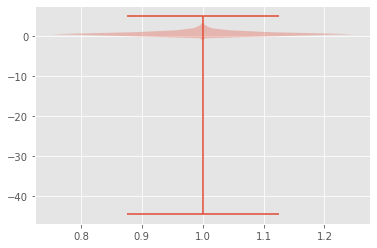

0.46109583333333326
0.3763


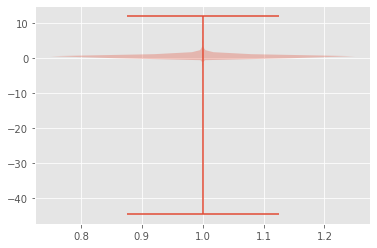

0.45230708333333336
0.34935000000000005


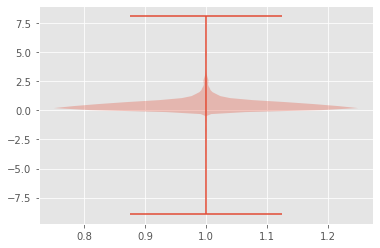

0.409444625
0.27140000000000003


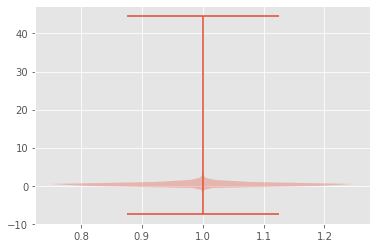

In [11]:
for i in range(len('seq_scored')):
    deg_pH10_df=train_df.deg_pH10.str[i]
    print(deg_pH10_df.mean())
    print(deg_pH10_df.median())
    plt.violinplot(deg_pH10_df)
    plt.show()

## Matrices de corrélation
**Corrélation entre les dégradations**

In [12]:
def item_mean(value_list):
    return np.mean(value_list)

In [13]:
# préparation des colonnes
to_name=['deg_pH10_mean','deg_Mg_pH10_mean','deg_50C_mean','deg_Mg_50C_mean','reactivity_mean']
from_name=[ 'deg_pH10', 'deg_Mg_pH10','deg_50C', 'deg_Mg_50C','reactivity']
for i in range(5):
    to_n=to_name[i]
    from_n=from_name[i]
    print(to_n,from_n)
    train_df[to_n]=train_df[from_n].apply(item_mean)

deg_pH10_mean deg_pH10
deg_Mg_pH10_mean deg_Mg_pH10
deg_50C_mean deg_50C
deg_Mg_50C_mean deg_Mg_50C
reactivity_mean reactivity


In [14]:
train_mean_df=train_df[{'deg_pH10_mean','deg_Mg_pH10_mean','deg_50C_mean','deg_Mg_50C_mean','reactivity_mean'}]

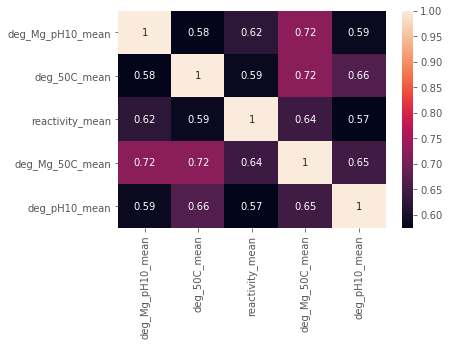

In [15]:
corrMatrix = train_mean_df.corr()

sn.heatmap(corrMatrix, annot=True)
plt.show()

## Relationship between targets

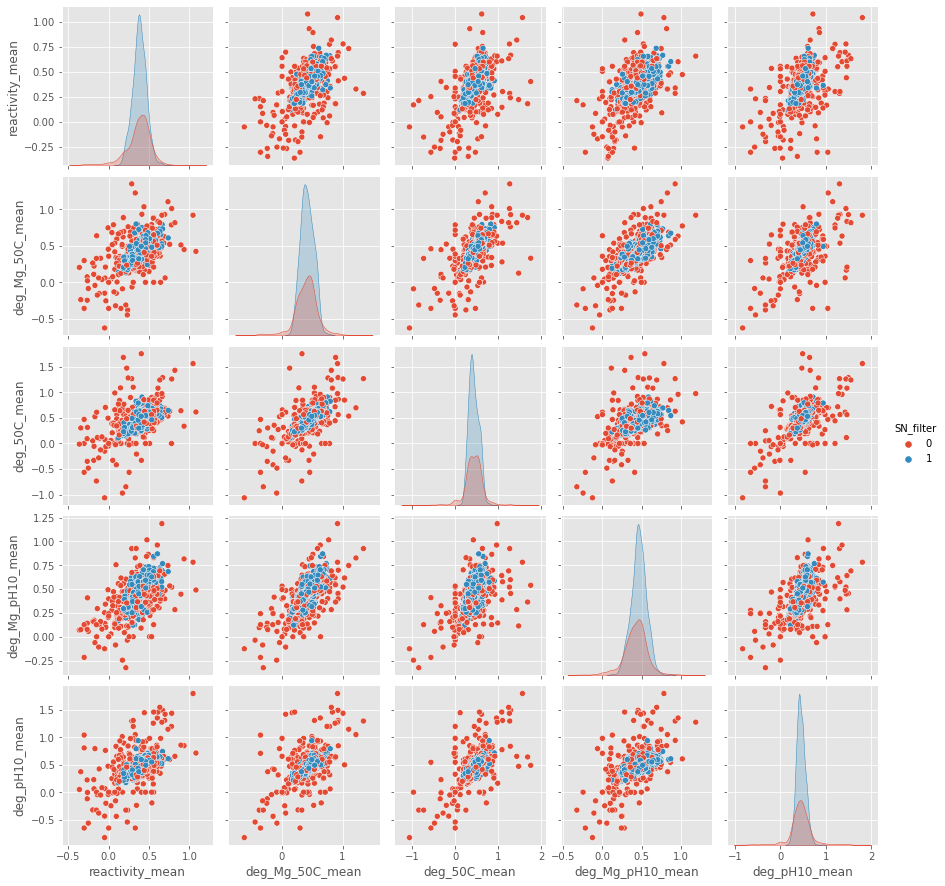

In [16]:
sns.pairplot(data=train_df,
             vars=['reactivity_mean',
                   'deg_Mg_50C_mean',
                    'deg_50C_mean',
                   'deg_Mg_pH10_mean',
                  'deg_pH10_mean'],
            hue='SN_filter')#Colored by SN_filter, elle sert à quoi SN_filter ? :p
plt.show()

**Corrélation entre les bases**

In [17]:
name='deg_pH10'
i=0
np.mean(train_df[name].str[0])

2.0051375833333336

In [18]:
def mean_on_item_column(column,i):
    values=column.str[i]
#     print(values)
    return np.mean(values)

In [19]:
# préparation des colonnes
from_name=[ 'deg_pH10', 'deg_Mg_pH10','deg_50C', 'deg_Mg_50C','reactivity']
parameters_for_each_base=pd.DataFrame(0, index=from_name, columns=list(range(68)))
print(parameters_for_each_base)
for i in range (68):
    for name in from_name:
        parameters_for_each_base.loc[name,i]=mean_on_item_column(train_df[name],i)
        
parameters_for_each_base

             0   1   2   3   4   5   6   7   8   9   ...  58  59  60  61  62  \
deg_pH10      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
deg_Mg_pH10   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
deg_50C       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
deg_Mg_50C    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
reactivity    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   

             63  64  65  66  67  
deg_pH10      0   0   0   0   0  
deg_Mg_pH10   0   0   0   0   0  
deg_50C       0   0   0   0   0  
deg_Mg_50C    0   0   0   0   0  
reactivity    0   0   0   0   0  

[5 rows x 68 columns]


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
deg_pH10,2.005138,2.923601,0.928780,0.722546,0.740868,0.680899,0.571747,0.461096,0.452307,0.409445,...,0.407300,0.394559,0.457730,0.422139,0.432254,0.467999,0.468921,0.467846,0.453545,0.941840
deg_Mg_pH10,0.594784,2.089024,0.722305,0.550928,0.695129,0.589534,0.515086,0.411426,0.428095,0.368775,...,0.437803,0.395689,0.446379,0.426576,0.419822,0.516840,0.597314,0.577760,0.498237,0.673022
deg_50C,0.612250,1.803313,1.019534,0.765357,0.746606,0.627279,0.562147,0.481785,0.484335,0.433881,...,0.393853,0.349833,0.360787,0.377142,0.391510,0.421597,0.458241,0.533046,0.462601,0.598597
deg_Mg_50C,0.476655,2.033298,0.962429,0.747399,0.856011,0.623050,0.511681,0.432986,0.449736,0.354612,...,0.369458,0.355625,0.385201,0.357709,0.368206,0.480367,0.563445,0.573512,0.501915,0.469470
reactivity,0.536378,1.513710,1.124513,0.833669,0.672602,0.458567,0.360533,0.298208,0.292377,0.293193,...,0.320005,0.305114,0.299979,0.306304,0.311137,0.303148,0.334632,0.403904,0.360276,0.324275


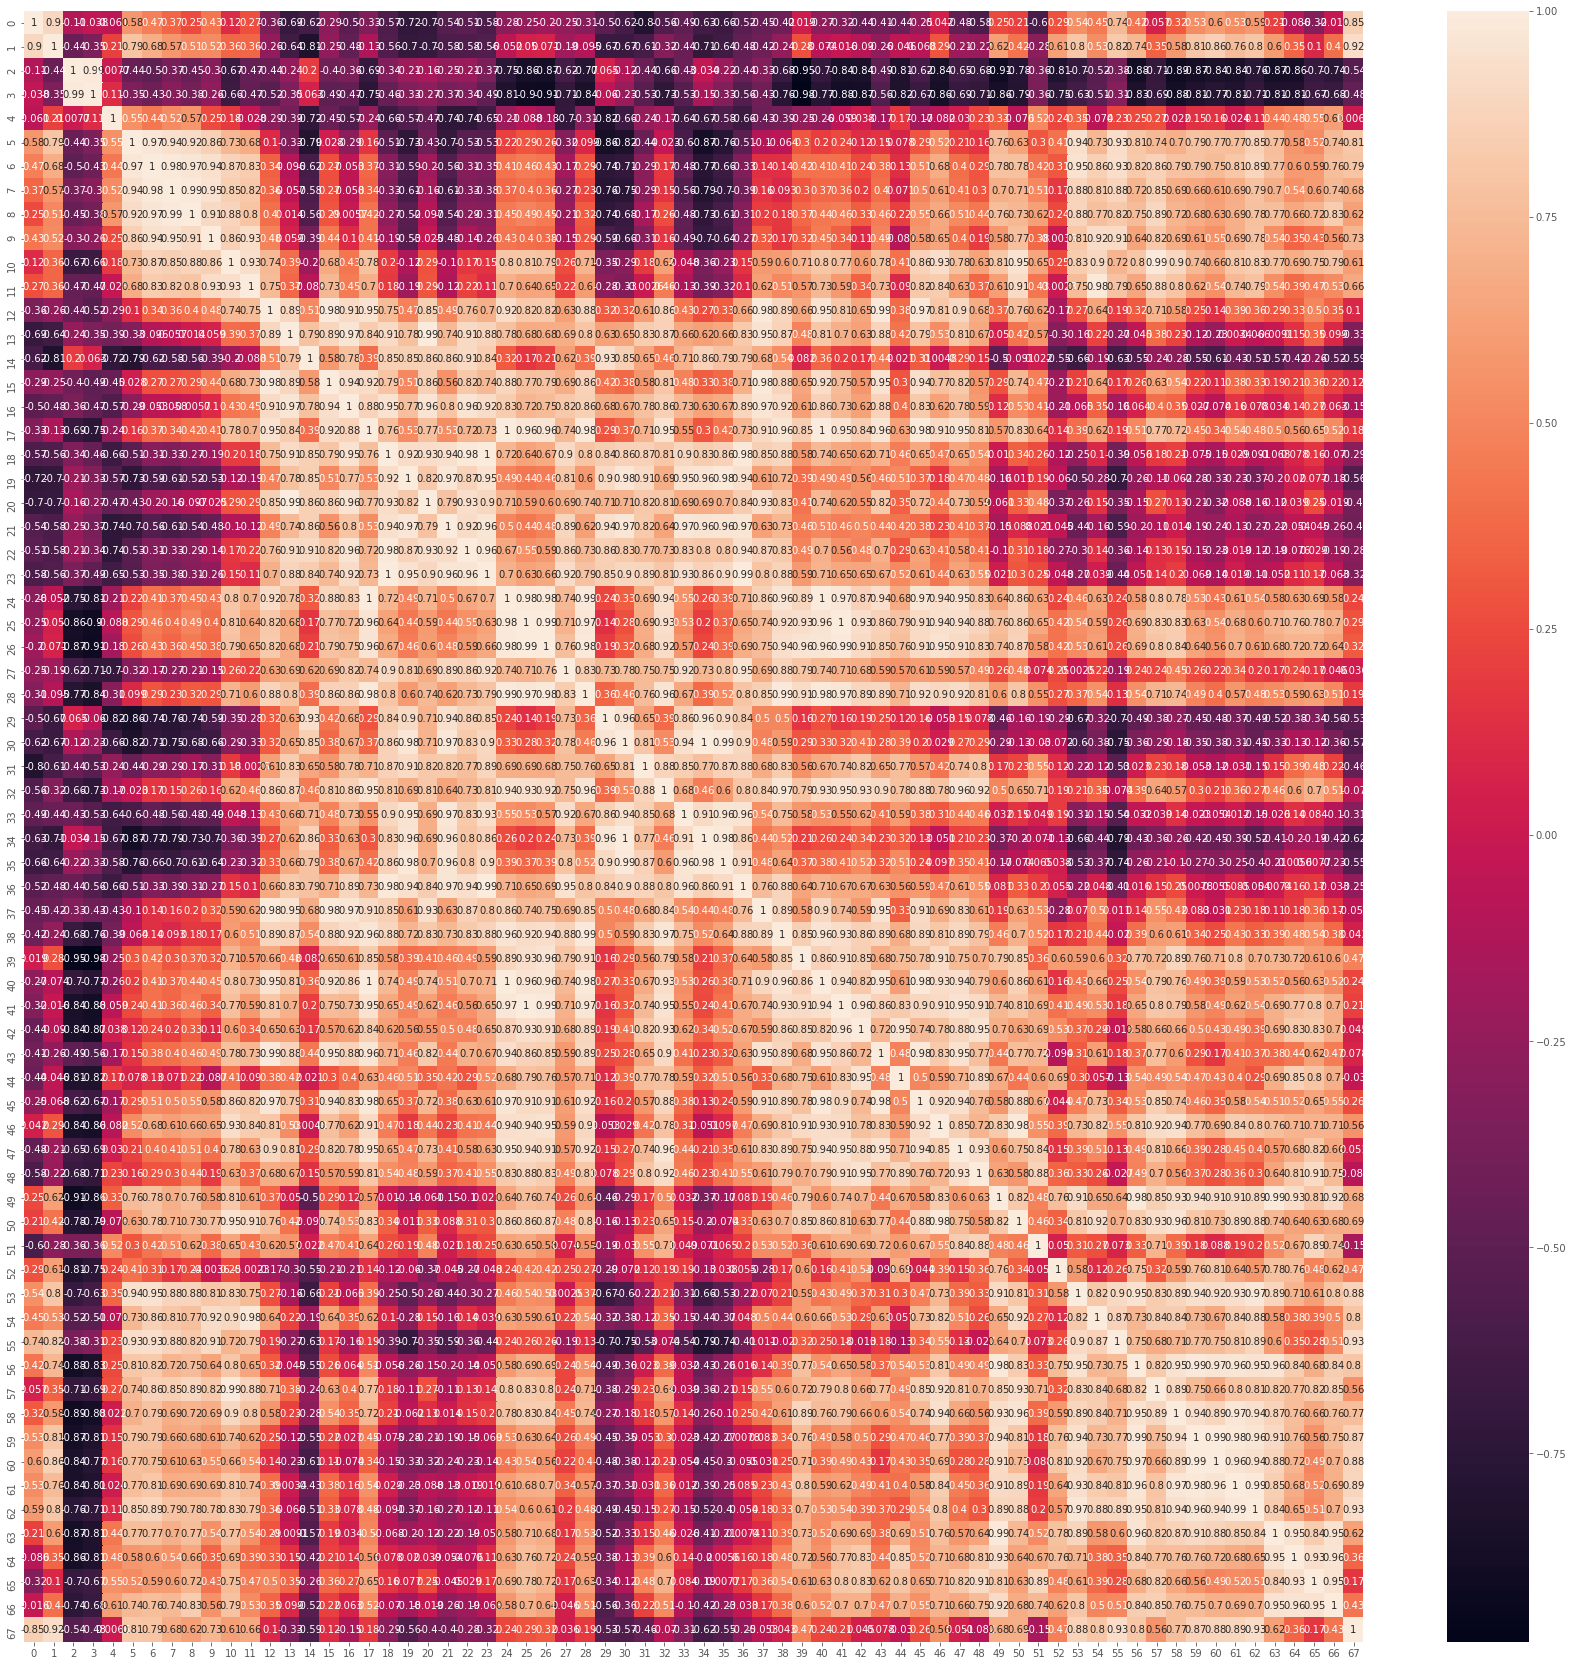

In [20]:
corrMatrix = parameters_for_each_base.corr()


fig, ax = plt.subplots(figsize=(30,30))
sn.heatmap(corrMatrix, annot=True, ax=ax)
plt.show()

## **New features** à revoir ou supprimer 

In [21]:
with open('train.json') as f:
    data = json.loads("[" + 
        f.read().replace("}\n{", "},\n{") + "]")

In [31]:
structure_list=[]
for i in range(len(train_df)):
    structure_list.append(data[i]['structure'][0:68])
loop_type_list=[]

for i in range(len(data)):
    loop_type_list.append(data[i]['predicted_loop_type'][0:68])
    
sequence_list=[]
for i in range(len(data)):
    sequence_list.append(data[i]['sequence'][0:68]) 

deg50_Mg_list=[]
for i in range(len(data)):
    deg50_Mg_list.append(data[i]['deg_Mg_50C'][0:68]) 
    
reactivity_list=[]
for i in range(len(data)):
    reactivity_list.append(data[i]['reactivity'][0:68]) 

deg50_pH10_list=[]
for i in range(len(data)):
    deg50_pH10_list.append(data[i]['deg_Mg_pH10'][0:68]) 

deg50_pH10_error_list=[]
for i in range(len(data)):
    deg50_pH10_error_list.append(data[i]['deg_error_Mg_pH10'][0:68]) 

reactivity_error_list=[]
for i in range(len(data)):
    reactivity_error_list.append(data[i]['reactivity_error'][0:68]) 
    
deg50_Mg_error_list=[]
for i in range(len(data)):
    deg50_Mg_error_list.append(data[i]['deg_error_Mg_50C'][0:68]) 
    
seq_length_list=[]
for i in range(len(data)):
    seq_length_list.append([data[i]['seq_length']])

# New feature - next base    
next_base_list=[]
for i in range(len(data)):
    next_base_list.append(sequence_list[i][1:]+'N')

# New feature - previous base
previous_base_list=[]
for i in range(len(data)):
    previous_base_list.append('N' + sequence_list[i][:-1])
    
# New feature - loop type at next base
next_loop_type_list=[]
for i in range(len(data)):
    next_loop_type_list.append(loop_type_list[i][1:]+'N')
    
# New feature - loop type at previous base
previous_loop_type_list=[]
for i in range(len(data)):
    previous_loop_type_list.append('N' + loop_type_list[i][:-1])

# New feature - total number of loop structures
loop_total_list=[]
for i in range(len(data)):
    loop_total_list.append([len(re.findall('\([.(]*\)', structure_list[i]))])

# New feature - percent GC of sequence
total_GC_list=[]
for i in range(len(data)):
    total_GC_list.append([(sequence_list[i].count('G')+sequence_list[i].count('C'))/len(sequence_list[i])])

In [32]:
def base_pairing_2(structure, sequence):
    '''
    finds the base paired to each base in a '(' or ')' structure
    creates a string the length of the sequence with the paired bases or 'N' for no pair
    '''
    base_pairing_list = ['N'] * len(sequence)
    open_counts=0
    close_counts=0
    open_positions=[]
    close_positions=[]
    open_positions_temp=[]
    close_positions_temp=[]
    for i , j in enumerate(structure):  
        if j == "(":
            open_counts += 1
            open_positions_temp.append(i)
        elif j == ")":
            close_counts += 1
            close_positions_temp.append(i)
        else:
            continue
        if open_counts == close_counts:
            open_positions.append(open_positions_temp)
            close_positions.append(close_positions_temp)
            open_positions_temp=[]
            close_positions_temp=[]
    for i in range(len(open_positions)):
        for j , k in zip(open_positions[i], close_positions[i][::-1]):
            base_pairing_list[k] = sequence[j]
            base_pairing_list[j] = sequence[k]
    return base_pairing_list


In [33]:
base_pairing_list = []
for i in range(len(data)):
    base_pairing_list.append(base_pairing_2(structure_list[i],sequence_list[i]))

In [34]:
def structure_type_length(structure):
    '''
    finds the length of each loop structure from opening '(' to closing ')'
    makes a string the length of the sequence with numbers representing the length of the current loop 
    '''
    structure=structure
    structure_length_list=[]
    prev_char=None
    length=None
    count=1
    for i in structure:
        if i != prev_char:
            if prev_char != None:
                length=count
                structure_length_list.extend([length] * length)
            count = 1
            prev_char= i
        else:
            count += 1
    if length:
        length=count
        structure_length_list.extend([length] * length)
    if not length:
        structure_length_list.extend([len(structure)]*len(structure))
    return structure_length_list

In [35]:
structure_type_length_list = []
for i in range(len(data)):
    structure_type_length_list.append(structure_type_length(structure_list[i]))

In [36]:
def splitintochars(a_list_of_lists):
    'splits lists of strings into lists of individual elements'
    final=[]
    for i in a_list_of_lists:
        final=final+[char for char in i]
    return final
    

def long_form(a_list_of_lists):
    'takes a list of sequences and converts it into a 1-dimensional array'
    temp=splitintochars(a_list_of_lists)
    temp=np.array(temp)
    temp = np.reshape(temp,[-1,1])
    temp = temp.flatten()
    return temp


def long_form2(a_list_of_lists):
    'takes a list of elements and converts it into a 1-dimensional array'
    long_list=[]
    for i in a_list_of_lists:
        for j in range(len(i)):
            long_list.append(i[j])
    temp=np.array(long_list)
    temp = np.reshape(temp,[-1,1])
    temp = temp.flatten()
    return temp


In [37]:
sequence_list=long_form(sequence_list)

structure_list=long_form(structure_list)

loop_total_list=long_form2(loop_total_list)

loop_type_list=long_form(loop_type_list)

seq_length_list=long_form2(seq_length_list)

next_base_list=long_form(next_base_list)

previous_base_list=long_form(previous_base_list)

deg50_Mg_error_list=long_form2(deg50_Mg_error_list)

deg50_pH10_list=long_form2(deg50_pH10_list)

reactivity_list=long_form2(reactivity_list)

deg50_pH10_error_list=long_form2(deg50_pH10_error_list)

reactivity_error_list=long_form2(reactivity_error_list)

deg50_Mg_list=long_form2(deg50_Mg_list)

next_loop_type_list=long_form(next_loop_type_list)

previous_loop_type_list=long_form(previous_loop_type_list)
   
total_GC_list=long_form2(total_GC_list)

base_pairing_list=long_form(base_pairing_list)

structure_type_length_list=long_form2(structure_type_length_list)       

In [39]:
len(sequence_list)

163200

In [30]:
final_df=pd.DataFrame(data=({'base':sequence_list,'structure':structure_list,'total_loop':loop_total_list,'loop_type':loop_type_list \
                             ,'length':seq_length_list,'next_base':next_base_list,'previous_base':previous_base_list, \
                                 'deg50_Mg_error':deg50_Mg_error_list, 'deg50_Mg':deg50_Mg_list}), \
                          index=np.arange(len(sequence_list)))

final_df['position']=list(np.arange(1,69))*2400
final_df['structure_type_length']=structure_type_length_list
final_df['total_GC']=total_GC_list
final_df['base_pairing']=base_pairing_list
final_df['next_loop_type']=next_loop_type_list
final_df['previous_loop_type']=previous_loop_type_list    
final_df['reactivity']=reactivity_list
final_df['reactivity_error']=reactivity_error_list                         
final_df['deg50_pH10_error']=deg50_pH10_error_list
final_df['deg50_pH10']=deg50_pH10_list   

ValueError: could not broadcast input array from shape (163200) into shape (2400)

## One-hot encoding

**Define token to int function. Since mRNA only contains "ACGUBEHIMSX" characters, we are assigning an index for each character.**

In [183]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}


In [171]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

train_inputs = preprocess_inputs(train_df.loc[train_df.SN_filter == 1])
train_labels = np.array(train_df.loc[train_df.SN_filter == 1][target_cols].values.tolist()).transpose((0, 2, 1))


In [140]:
train_df_public['signal_to_noise'].head(10)

0     6.894
2     8.800
5     4.136
6     2.485
7     1.727
9     5.545
10    5.934
11    9.540
12    8.294
13    8.391
Name: signal_to_noise, dtype: float64

## Separation of the data between train and test

In [172]:
from sklearn.model_selection import train_test_split

seed = 123
X_train, X_test, Y_train, Y_test = train_test_split(train_inputs, train_la, test_size = 0.1, random_state = seed)

## Window method:

In [173]:

window_size=21 #doit être un nombre impair
print(len(X_train))
for i in range(68): #on parcourt toute la séquence
    start_index=int(i-(window_size-1)/2)
    stop_index=int(i+(window_size-1)/2 +1) #not included
    full_array=[]
    for sample_index in range(len(X_train)):
        sample_array=X_train[sample_index]

        if start_index<0:
            out_array=np.array([[-1]*len(sample_array[0])]*(-int(start_index)))
            studied_cut_array=sample_array[0:stop_index]
            studied_array=np.concatenate((out_array,studied_cut_array))

        elif stop_index>68:
            out_array=np.array([[-1]*len(sample_array[0])]*(int(stop_index-68)))
            studied_cut_array=sample_array[start_index:68]
            studied_array=np.concatenate((studied_cut_array,out_array))

        else :
            studied_array=sample_array[start_index:stop_index]
        full_array.append(studied_array)

    full_array=np.array(full_array)
    output=Y_train[:,i,:] #l'output attendu pour les données d'entraînement, de dimensions 2160(taille de X_train)*3
    
    #ici il faut faire le fit sur le full_array de dimensions 2160*21*14=nombredeséquences*window_size*nombredeparamètresd'input
    #ensuite on lance le modèle sur les vraies données, 
    #et on stocke le résultat [a,b,c] dans l'item i une liste du type [[1, 0, 0], [0, 1, 0.3], [0.4, 0.7, 1], ...], de dimensions 68*3

#à la fin on a une liste de 68 triplets (68*3

1430


## First model GRU

In [159]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, None, 15) <dtype: 'float32'>
(None, 68) <dtype: 'float32'>
conv1d_9 (None, None, 15) float32
global_max_pooling1d_10 (None, None, 10) float32
dense_37 (None, 10) float32
dense_38 (None, 20) float32
dropout_9 (None, 16) float32
dense_39 (None, 16) float32
dense_40 (None, 10) float32


[None, None, None, None, None, None, None]

According to the competition guideline, Mean Columnwise Root Mean Squared Error(𝑀𝐶𝑅𝑀𝑆𝐸) is the model evaluation formula.

𝑀𝐶𝑅𝑀𝑆𝐸 = 1𝑚∑𝑚𝑗=1𝑅𝑀𝑆𝐸𝑗

𝑚 - number of predicted variables

𝑛 - number of test samples

𝑦𝑖𝑗 - 𝑖-th actual value of 𝑗​-th variable

𝑦𝑖𝑗 - 𝑖-th predicted value of 𝑗-th variable

The MCRMSE is simply an average across all RMSE values for each of our columns. It can allow us to use a single-number evaluation metric, even in the case of multiple outputs.

In [182]:
y_true = tf.random.normal((32, 68, 3))
y_pred = tf.random.normal((32, 68, 3))
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

In [174]:
import tensorflow.keras.layers as L
def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True))

def build_model(seq_len=107, pred_len=68, dropout=0.5, embed_dim=75, hidden_dim=128):
    inputs = L.Input(shape=(seq_len, 3))

    embed = L.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs)
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))

    hidden = gru_layer(hidden_dim, dropout)(reshaped)
    hidden = gru_layer(hidden_dim, dropout)(hidden)
    hidden = gru_layer(hidden_dim, dropout)(hidden)
    
    # Since we are only making predictions on the first part of each sequence, we have
    # to truncate it
    truncated = hidden[:, :pred_len]
    
    out = L.Dense(5, activation='linear')(truncated)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    model.compile(tf.keras.optimizers.Adam(), loss=MCRMSE)
    
    return model

In [175]:
model = build_model(embed_dim=len(token2int))
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 107, 3, 14)        196       
_________________________________________________________________
tf_op_layer_Reshape_2 (Tenso [(None, 107, 42)]         0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 107, 256)          132096    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 107, 256)          296448    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 107, 256)          296448    
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 68, 256)]         0   

In [176]:
history = model.fit(
    X_train, 
    Y_train,
    validation_data=(X_test, Y_test),
    batch_size=64,
    epochs=60,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=5),
        tf.keras.callbacks.ModelCheckpoint('model.h5')
    ]
)

Epoch 1/60
23/23 - 32s - loss: 0.4754 - val_loss: 0.4223 - lr: 0.0010
Epoch 2/60
23/23 - 33s - loss: 0.4043 - val_loss: 0.3781 - lr: 0.0010
Epoch 3/60
23/23 - 39s - loss: 0.3780 - val_loss: 0.3664 - lr: 0.0010
Epoch 4/60
23/23 - 32s - loss: 0.3680 - val_loss: 0.3558 - lr: 0.0010
Epoch 5/60
23/23 - 31s - loss: 0.3569 - val_loss: 0.3416 - lr: 0.0010
Epoch 6/60
23/23 - 31s - loss: 0.3459 - val_loss: 0.3311 - lr: 0.0010
Epoch 7/60
23/23 - 30s - loss: 0.3394 - val_loss: 0.3266 - lr: 0.0010
Epoch 8/60
23/23 - 30s - loss: 0.3335 - val_loss: 0.3249 - lr: 0.0010
Epoch 9/60
23/23 - 31s - loss: 0.3291 - val_loss: 0.3150 - lr: 0.0010
Epoch 10/60
23/23 - 33s - loss: 0.3250 - val_loss: 0.3135 - lr: 0.0010
Epoch 11/60
23/23 - 33s - loss: 0.3223 - val_loss: 0.3107 - lr: 0.0010
Epoch 12/60
23/23 - 31s - loss: 0.3196 - val_loss: 0.3061 - lr: 0.0010
Epoch 13/60
23/23 - 30s - loss: 0.3164 - val_loss: 0.3015 - lr: 0.0010
Epoch 14/60
23/23 - 30s - loss: 0.3142 - val_loss: 0.3094 - lr: 0.0010
Epoch 15/60
23/

## Evaluate training history
quickly visualize the training and validation loss throughout the epochs.

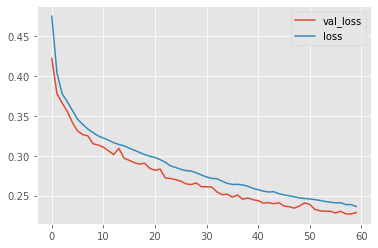

In [181]:

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['val_loss', 'loss'], loc='upper right')